<a href="https://colab.research.google.com/github/daegeunbae/daegeunbae/blob/main/240312_CRM_Analytics_RFM%2C_Cohort_Analysis%2C_CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install lifetimes

In [2]:
#pip install squarify

In [3]:
#https://www.kaggle.com/code/serdarsozturk/crm-analytics-rfm-cohort-analysis-clv
import pandas as pd
import numpy as np
import warnings
from datetime import datetime

# Beklenti hesaplamak için kullanacağımız kütüphaneler.
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
# Görselleştirme için kullandığımız kütüphaneler.
from lifetimes.plotting import plot_period_transactions
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
from operator import attrgetter
import squarify
sns.set_style('whitegrid')
palette = 'Set2'

# Birtakım ayarlar.
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df2 = pd.read_csv('/content/drive/MyDrive/02.coding/10.Team_Project/08.고객이탈예측_CLV/churn2.csv')
df2.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No


In [5]:
df = pd.read_excel('/content/drive/MyDrive/02.coding/10.Team_Project/08.고객이탈예측_CLV/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df_ = df.copy()
df.head(4)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


## InvoiceNo: 송장 번호. 명사 같은. 각 거래에 고유하게 할당된 6자리 정수
이 코드가 문자 'c'로 시작하면 취소(파투라 누마라시)
StockCode: 상품(품목) 코드

명사 같은. 각 개별 제품에 고유하게 할당된 5자리 정수
설명: 제품(항목) 이름

수량: 거래당 각 제품(품목)의 수량

InvoiceDate: 송장 날짜 및 시간

숫자. 거래가 발생한 날짜와 시간

단가: 숫자. 단위당 제품 가격(파운드)

고객 ID: 고객 번호 명사 같은. 각 고객에게 고유하게 할당된 5자리 정수

국가: 국가 이름. 명사 같은. 고객이 거주하는 국가의 이름

### DATA UNDERSTANDING

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" DESCRIBE ".center(70,'-'))
    print(dataframe.describe([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]).T)

check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 541910
Columns: 8
------------------------------- TYPES --------------------------------
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
-------------------------------- HEAD --------------------------------
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00  2.550    17850.000  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00  3.390    17850.000  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00  2.750    17850.000  United Kingdom
3  536365    8402

In [8]:
df["Description"].nunique()

4223

In [9]:
df["Description"].value_counts().head(10)

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
Name: Description, dtype: int64

In [10]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df["TotalPrice"].head()

0   15.300
1   20.340
2   22.000
3   20.340
4   20.340
Name: TotalPrice, dtype: float64

In [11]:
df.groupby("Description").agg({"Quantity": "sum"}).sort_values("Quantity", ascending=False).head().style.set_properties(**{"background-color": "#000000","color":"#FFEA20","border": "0.2px solid white"})

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
JUMBO BAG RED RETROSPOT,47363
ASSORTED COLOUR BIRD ORNAMENT,36381
POPCORN HOLDER,36334
PACK OF 72 RETROSPOT CAKE CASES,36039


In [12]:
df['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8558
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [13]:
df.columns = df.columns.str.replace(' ', '')
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'CustomerID', 'Country', 'TotalPrice'], dtype='object')

In [14]:
world_map = df[['CustomerID', 'Invoice', 'Country']
              ].groupby(['CustomerID', 'Invoice', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

### DATA PREPARATION

In [15]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [16]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406830 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406830 non-null  object        
 1   StockCode    406830 non-null  object        
 2   Description  406830 non-null  object        
 3   Quantity     406830 non-null  int64         
 4   InvoiceDate  406830 non-null  datetime64[ns]
 5   Price        406830 non-null  float64       
 6   CustomerID   406830 non-null  float64       
 7   Country      406830 non-null  object        
 8   TotalPrice   406830 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [17]:
# 'Invoice' 열을 문자열로 변환한 후 'C'를 포함하지 않는 행들만 df에 담기
df = df[~df['Invoice'].astype(str).str.contains('C', na=False)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397925 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397925 non-null  object        
 1   StockCode    397925 non-null  object        
 2   Description  397925 non-null  object        
 3   Quantity     397925 non-null  int64         
 4   InvoiceDate  397925 non-null  datetime64[ns]
 5   Price        397925 non-null  float64       
 6   CustomerID   397925 non-null  float64       
 7   Country      397925 non-null  object        
 8   TotalPrice   397925 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


### CALCULATING RFM METRICS

In [18]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [19]:
today_date = datetime(2011, 12, 11)
# RFM metriklerini hesaplayalım..
# Recency : Müşterinin son alışverişinin üzerinden geçen zaman.
# Frequency: Müşterinin toplam alışveriş sayısı
# Monetary: Müşterinin tüm süreçte toplam bıraktığı para

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                     'Invoice': lambda x: x.nunique(),
                                     'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
# İadelerden doğabilecek negatif değerleri ve 0 değerleri kaldıralım.
rfm = rfm[rfm["monetary"] > 0]

rfm.head().style.set_properties(**{"background-color": "#000000","color":"#FFEA20","border": "0.2px solid white"})

,recency,frequency,monetary
CustomerID,,,
12346.000000,326,1,77183.600000
12347.000000,3,7,4310.000000
12348.000000,76,4,1797.240000
12349.000000,19,1,1757.550000
12350.000000,311,1,334.400000


In [20]:
rfm.dtypes

recency        int64
frequency      int64
monetary     float64
dtype: object

In [21]:
def get_rfm_scores(dataframe):

    dataframe["recency_score"] = pd.qcut(dataframe["recency"], 5, labels=[5, 4, 3, 2, 1])
    dataframe["frequency_score"] = pd.qcut(dataframe["frequency"].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    dataframe["monetary_score"] = pd.qcut(dataframe["monetary"], 5, labels=[1, 2, 3, 4, 5])
    dataframe["RFM_SCORE"] = dataframe["recency_score"].astype(str) + dataframe["frequency_score"].astype(str)

    return dataframe

get_rfm_scores(rfm)
rfm = rfm.reset_index()
rfm.head().style.set_properties(**{"background-color": "#000000","color":"#FFEA20","border": "0.2px solid white"})

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346.000000,326,1,77183.600000,1,1,5,11
1,12347.000000,3,7,4310.000000,5,5,5,55
2,12348.000000,76,4,1797.240000,2,4,4,24
3,12349.000000,19,1,1757.550000,4,1,4,41
4,12350.000000,311,1,334.400000,1,1,2,11


### CREATING & ANALYISIN RFM SEGMENTS

In [22]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head().style.set_properties(**{"background-color": "#000000","color":"#FFEA20","border": "0.2px solid white"})

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.000000,326,1,77183.600000,1,1,5,11,hibernating
1,12347.000000,3,7,4310.000000,5,5,5,55,champions
2,12348.000000,76,4,1797.240000,2,4,4,24,at_Risk
3,12349.000000,19,1,1757.550000,4,1,4,41,promising
4,12350.000000,311,1,334.400000,1,1,2,11,hibernating


In [23]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"]).style.set_properties(**{"background-color": "#000000","color":"#FFEA20","border": "0.2px solid white"})

In [24]:
rfm[rfm["segment"] == "cant_loose"].head().style.set_properties(**{"background-color": "#000000","color":"#FFEA20","border": "0.2px solid white"})

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
241,12643.000000,129,6,3344.640000,2,5,5,25,cant_loose
400,12853.000000,135,6,1957.100000,2,5,4,25,cant_loose
410,12868.000000,186,6,1607.060000,1,5,4,15,cant_loose
464,12947.000000,144,6,1603.990000,2,5,4,25,cant_loose
485,12980.000000,158,9,7374.900000,2,5,5,25,cant_loose


### RFM MODEL EVALUATION & COHORT ANALYSIS

In [24]:
print(' RFM Model Evaluation '.center(70, '*'))
X = rfm[['recency_score', 'frequency_score']]
labels = rfm['segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"*"}')

In [24]:
background = "#313332"
backgroundr = "#6D6D6D"
text_color = "w"
title_font="Alegreya Sans"

plt.figure(figsize=(20,15))
fig, ax = plt.subplots(figsize=(20,10))
ax.patch.set_facecolor(backgroundr)
fig.set_facecolor(backgroundr)
fig.facecolor="white"
fig.edgecolor="white"

ax.grid(ls="dotted",lw=0.5,color="lightgrey",zorder=1)
bar_ap = sns.countplot(data = rfm,
                   x = 'segment')
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
bar_ap.set_xticklabels(bar_ap.get_xticklabels(), rotation=90)
plt.title('Number of Customers by Segments', size = 16, color=text_color)
plt.ylabel('Count', size = 14,color="white" )
plt.xlabel("SEGMENT",fontsize = 14,color="white" )
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

In [24]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=[
        "#AFB6B5",
        "#F0819A",
        "#926717",
        "#F0F081",
        "#81D5F0",
        "#C78BE5",
        "#748E80",
        "#FAAF3A",
        "#7B8FE4",
        "#86E8C0",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()

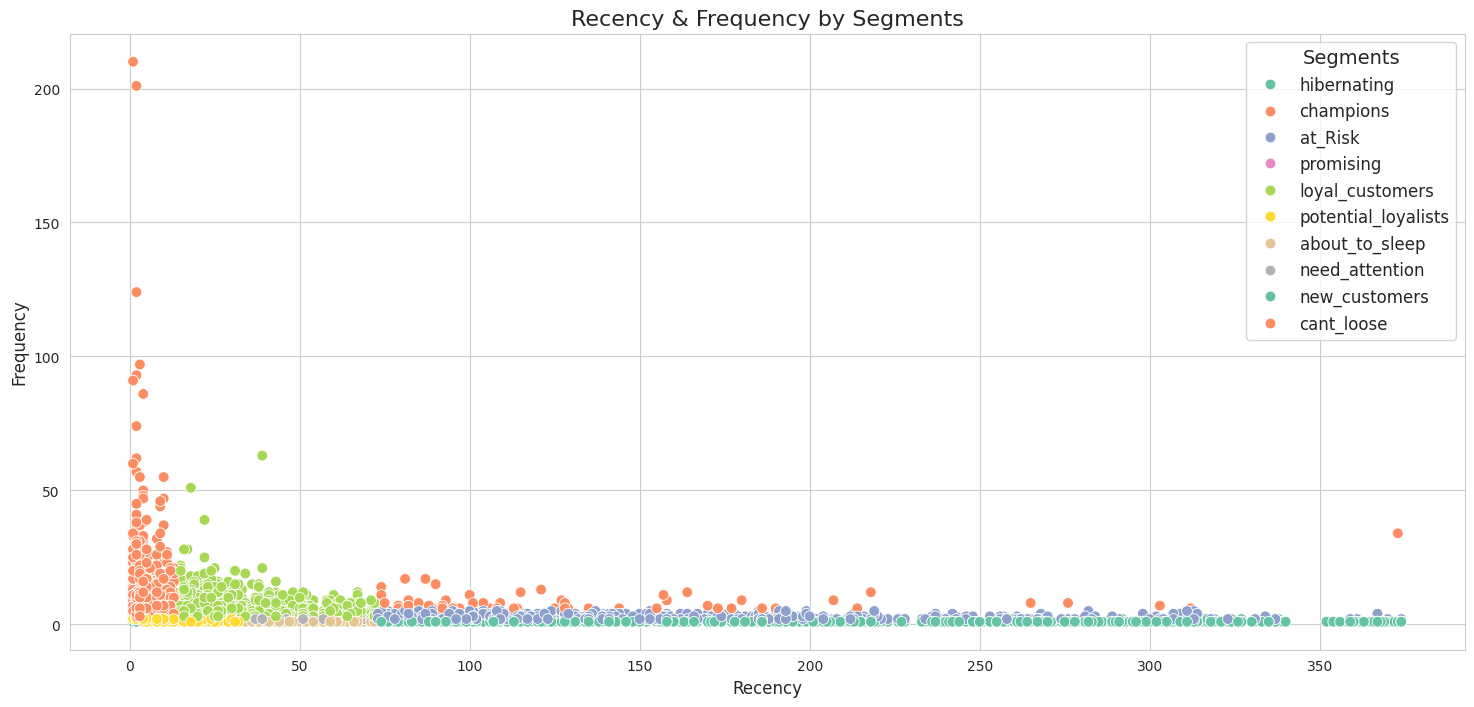

In [25]:
plt.figure(figsize=(18, 8))
sns.scatterplot(data=rfm, x="recency", y="frequency", hue="segment", palette=palette, s=60)
plt.title("Recency & Frequency by Segments", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.show()

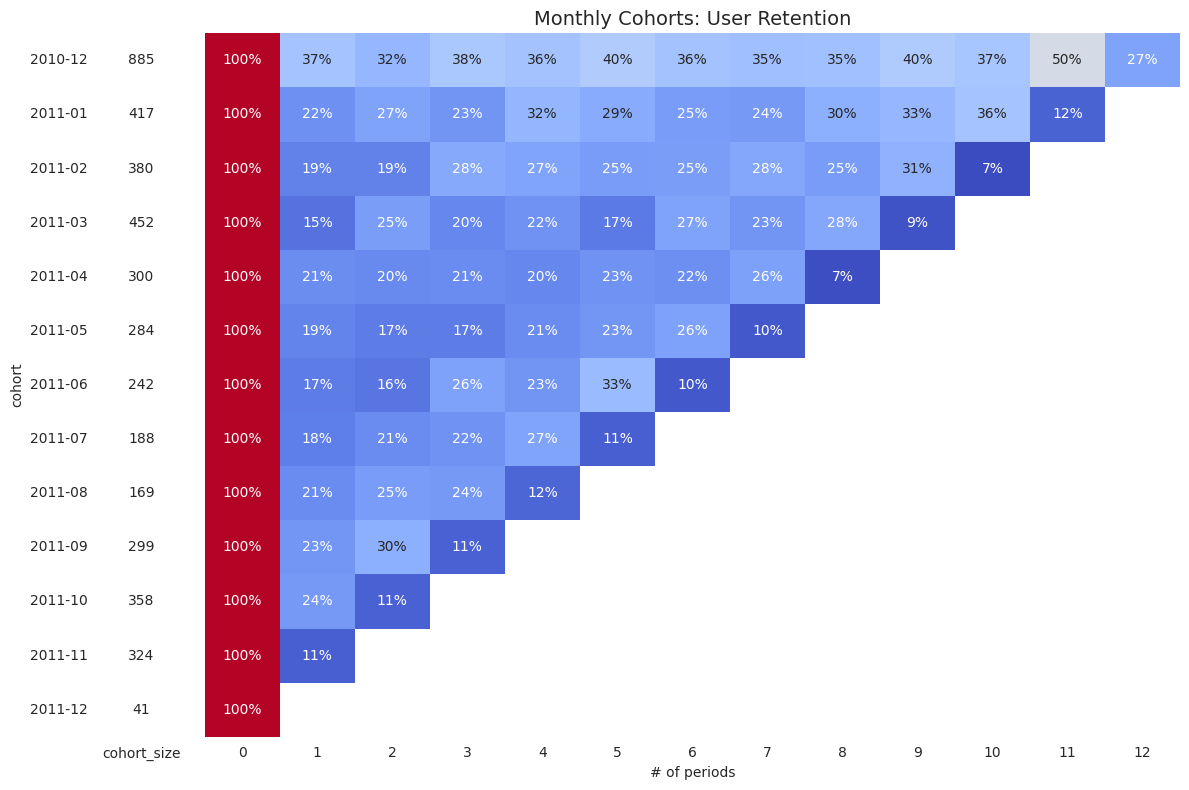

In [26]:
def CohortAnalysis(dataframe):

    dataframe = dataframe[["CustomerID", "Invoice", "InvoiceDate"]].drop_duplicates()
    dataframe["order_month"] = dataframe["InvoiceDate"].dt.to_period("M")
    dataframe["cohort"] = (dataframe.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M"))
    cohort_data = (dataframe.groupby(["cohort", "order_month"]).agg(n_customers=("CustomerID", "nunique")).reset_index(drop=False))
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(attrgetter("n"))
    cohort_pivot = cohort_data.pivot_table(index="cohort", columns="period_number", values="n_customers")
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]})
        sns.heatmap(retention_matrix,mask=retention_matrix.isnull(), annot=True, cbar=False, fmt=".0%", cmap="coolwarm", ax=ax[1],)
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),annot=True,cbar=False,fmt="g",cmap=white_cmap,ax=ax[0],)
        fig.tight_layout()

CohortAnalysis(df)

In [ ]:
rfm.to_csv("/content/drive/MyDrive/02.coding/10.Team_Project/08.고객이탈예측_CLV/rfm.csv")